In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data load

In [ ]:
df = pd.read_csv('/home/sbml/BADA/selected_HIs.csv')

In [8]:
HIs = df.columns[:-2]
print('The number of HIs: ', len(HIs))
print('HIs_names: ', list(HIs))

The number of HIs:  5
HIs_names:  ['dis_v_end', 'dis_v_area', 'dis_v_std', 'v_skew', 'v_kurtosis']


# Multi objective transformer construction

In [12]:
import tensorflow as tf

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential

In [14]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))

    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [15]:
def encoder_block(num_layer, x, drop1, drop2, dff, d_model):
  heads = 8
  n = d_model//heads  # num_heads=heads
  i = num_layer

  ## mulit_head_attention (sublayer 1)
  norm1 = layers.LayerNormalization(epsilon=1e-6,name=f'layer_norm1_{i+1}')(x)
  attention_output, attention_weight = layers.MultiHeadAttention(num_heads=heads, key_dim=n, value_dim=n, dropout=drop1, name=f'mulit_head{i+1}')(query=norm1, key=norm1, value=norm1, return_attention_scores=True)
  x = layers.Add(name=f'residual_connection1_{i+1}')([x, attention_output])

  ## feed_forward (sublayer 2)
  norm2  = layers.LayerNormalization(epsilon=1e-6, name=f'layer_norm2_{i+1}')(x)
  ffn = layers.Dense(dff, activation='gelu', name=f'FFN1_{i+1}')(norm2)
  ffn = layers.Dense(d_model, name=f'FFN2_{i+1}')(ffn)
  ffn = layers.Dropout(rate=drop2)(ffn)
  x = layers.Add(name=f'residual_connection2_{i+1}')([x, ffn])
  return x, attention_weight

In [16]:
def estimator(seq_len, input_dim, d_model, drop1, drop2, dff, reg_fc):
  ## input embedding
  inputs = layers.Input(shape=(seq_len,), name='inputs')
  embedding = layers.Embedding(input_dim=input_dim, output_dim=d_model, name='input_embedding')(inputs)

  ## positional encoding
  pos_enc = positional_encoding(seq_len, d_model)

  x = embedding + pos_enc

  ## encoders
  attention_weight_l = []
  for i in range(4):
    x, attention_weight = encoder_block(i, x, drop1, drop2, dff, d_model)
    attention_weight_l.append(attention_weight)

  ## regression
  pool = layers.GlobalAveragePooling1D()(x)
  outputs = layers.Dense(reg_fc, activation='relu', name='FC1')(pool)
  outputs = layers.Dense(1, name='FC2')(outputs)

  model = tf.keras.Model(inputs=inputs, outputs=[outputs, attention_weight_l])
  model.summary()
  return model

In [17]:
def classifier(seq_len, input_dim, d_model, drop1, drop2, dff, reg_fc):
  ## input embedding
  inputs = layers.Input(shape=(seq_len,), name='inputs')
  embedding = layers.Embedding(input_dim=input_dim, output_dim=d_model, name='input_embedding')(inputs)

  ## positional encoding
  pos_enc = positional_encoding(seq_len, d_model)

  x = embedding + pos_enc

  ## encoders
  attention_weight_l = []
  for i in range(4):
    x, attention_weight = encoder_block(i, x, drop1, drop2, dff, d_model)
    attention_weight_l.append(attention_weight)

  ## classification
  pool = layers.GlobalAveragePooling1D()(x)
  #outputs = layers.Dense(reg_fc1, name='FC1')(pool)
  outputs = layers.Dense(reg_fc, activation='relu', name='FC1')(pool)
  outputs = layers.Dense(1, activation='sigmoid', name='FC2')(outputs)

  model = tf.keras.Model(inputs=inputs, outputs=[outputs, attention_weight_l])
  model.summary()
  return model

## SoH estimator

## 0. data split

In [65]:
d_cell = df[df['label']==0]
X_cell = d_cell[HIs].values
y_cell = d_cell[['soh']].values

In [ ]:
def labeled_soh(soh):
  soh_l = []
  for i in soh:
    if 0.95 <= i <= 1:
      soh_l.append(1)
    elif 0.9 <= i < 0.95:
      soh_l.append(2)
    elif 0.85 <= i < 0.9:
      soh_l.append(3)
    elif 0.8 <= i < 0.85:
      soh_l.append(4)
    elif 0.75 <= i < 0.8:
      soh_l.append(5)
    elif 0.7 <= i < 0.75:
      soh_l.append(6)
    else:
      soh_l.append(7)

  label_l = np.array(soh_l)
  return label_l

In [ ]:
def data_split(X, label_l, y, rate):
  sss = StratifiedShuffleSplit(n_splits=5, test_size=rate)
  for train_index, test_index in sss.split(X, label_l):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
  label_test_l = label_l[test_index]
  return X_train, y_train, X_test, y_test,label_test_l

In [66]:
label_l = labeled_soh(y_cell)
X_train, y_train, X_test, y_test, label_test_l = data_split(X_cell,label_l, y_cell, 0.2)
X_test_f, y_test_f, X_val, y_val, _ = data_split(X_test, label_test_l, y_test, 0.5)

X_train, y_train = X_train, y_train
X_test, y_test = X_test_f, y_test_f
X_val, y_val = X_val, y_val

## 1. model train

In [67]:
seq_len = len(HIs)

In [68]:
input_dim = 512

In [69]:
reg_model = estimator(seq_len=seq_len, input_dim=input_dim, d_model=64, drop1=0.1, drop2=0.1, dff=256, reg_fc=16)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_embedding           │ (None, 5, 64)          │         32,768 │ inputs[0][0]           │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 5, 64)          │              0 │ input_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_1             │ (None, 5, 64)          │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head1               │ [(None, 5, 64), (None, │         16,640 │ layer_norm1_1[0][0],   │
│ (MultiHeadAttention)      │ 8, 5, 5)]              │                │ layer_norm1_1[0][0],   │
│                           │                        │                │ layer_norm1_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_1    │ (None, 5, 64)          │              0 │ add_2[0][0],           │
│ (Add)                     │                        │                │ mulit_head1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm2_1             │ (None, 5, 64)          │            128 │ residual_connection1_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN1_1 (Dense)            │ (None, 5, 256)         │         16,640 │ layer_norm2_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN2_1 (Dense)            │ (None, 5, 64)          │         16,448 │ FFN1_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 5, 64)          │              0 │ FFN2_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection2_1    │ (None, 5, 64)          │              0 │ residual_connection1_… │
│ (Add)                     │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_2             │ (None, 5, 64)          │            128 │ residual_connection2_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head2               │ [(None, 5, 64), (None, │         16,640 │ layer_norm1_2[0][0],   │
│ (MultiHeadAttention)      │ 8, 5, 5)]              │                │ layer_norm1_2[0][0],   │
│                           │                        │                │ layer_norm1_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_2    │ (None, 5, 64)          │              0 │ residual_connection2_… │
│ (Add)                     │                        │                │ mulit_head2[0][0]      │
├──────────────────────

 Total params: 233,761 (913.13 KB)

 Trainable params: 233,761 (913.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', baseline=None, restore_best_weights=True)

In [ ]:
epochs=50
batch_size=64
adam = optimizers.Adam() # learning_rate=1e-4
reg_model.compile(loss=['mean_squared_error', None], optimizer = adam)
hist = reg_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.1, callbacks=[early_stopping])  #, callbacks=[early_stopping]
hist

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 481ms/step - loss: 1.3481 - val_loss: 0.0123
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0052
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0037
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 9.8310e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 8.5495e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 4.0601e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 3.5049e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - lo

In [ ]:
score = reg_model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ', score)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 2.1394e-04
Test loss:  0.00020598895207513124


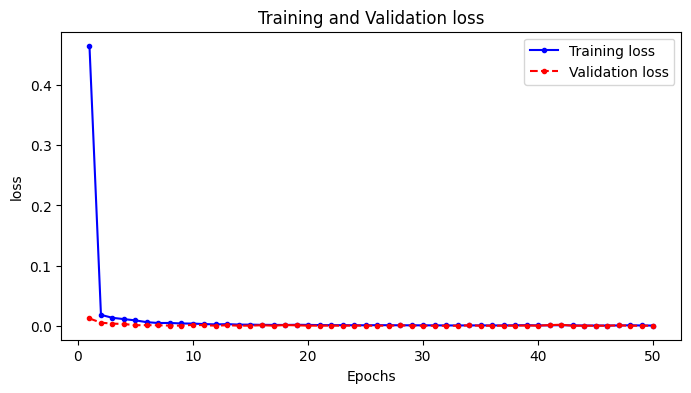

In [ ]:
plt.figure(figsize=(8,4))
n = range(1, len(hist.history['loss'])+1)
plt.plot(n,hist.history['loss'], 'b', marker='.', label='Training' + ' loss')
plt.plot(n,hist.history['val_loss'], 'r--', marker='.', label='Validation' + ' loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

## 2. model test



### applied to the trained cell



In [ ]:
c_pred, att = reg_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0.5, 1.0, 'After Feature Selection')

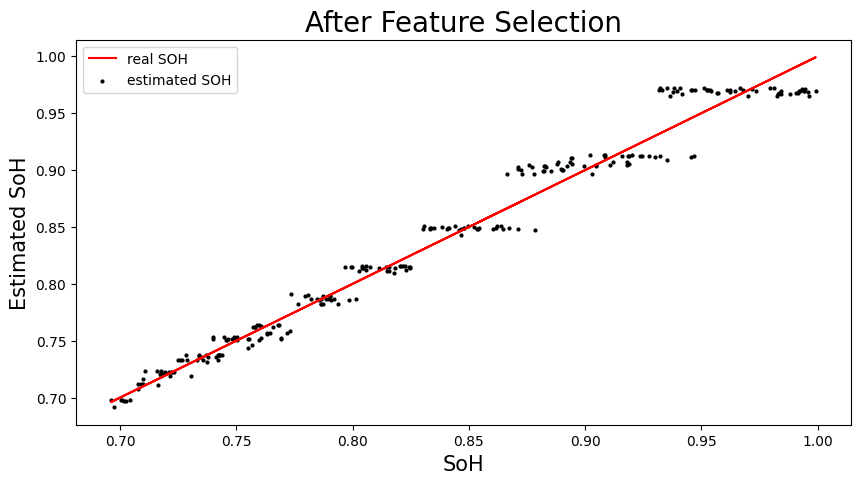

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test, y_test, color='r', label='real SOH')
plt.scatter(y_test, c_pred, color='black', s=4, label = 'estimated SOH')
plt.legend()
plt.xlabel('SoH', size=15)
plt.ylabel('Estimated SoH', size=15)
plt.title('After Feature Selection', size=20)

In [ ]:
r2 = r2_score(y_test, c_pred)
rmse = mean_squared_error(y_test, c_pred)**0.5
mse = mean_squared_error(y_test, c_pred)
mae = mean_absolute_error(y_test, c_pred)
mape = mean_absolute_percentage_error(y_test, c_pred)
print(r2)
print(rmse)

0.9741219252747553
0.014197662856521345




### applied to the 7P module



In [ ]:
d_module = df[df['label']==1]
X_module = d_module[HIs].values
y_module = d_module[['soh']].values

In [ ]:
m_pred, att = reg_model.predict(X_module)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Text(0.5, 1.0, 'After Feature Selection')

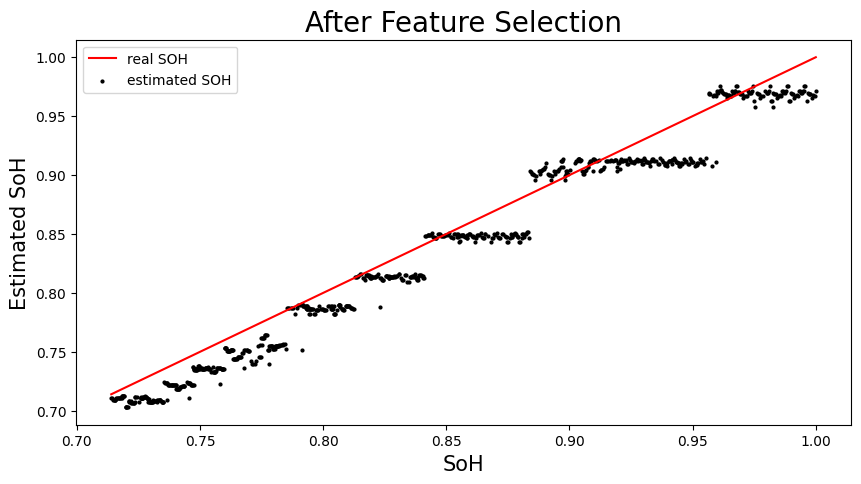

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_module, y_module, color='r', label='real SOH')
plt.scatter(y_module, m_pred, color='black', s=4, label = 'estimated SOH')
plt.legend()
plt.xlabel('SoH', size=15)
plt.ylabel('Estimated SoH', size=15)
plt.title('After Feature Selection', size=20)

In [ ]:
r2 = r2_score(y_module, m_pred)
rmse = mean_squared_error(y_module, m_pred)**0.5
mse = mean_squared_error(y_module, m_pred)
mae = mean_absolute_error(y_module, m_pred)
mape = mean_absolute_percentage_error(y_module, m_pred)
print(r2)
print(rmse)

0.9496222074620764
0.01888453465912691


# Configuration classifier

## 0. data split

In [18]:
d_cell = df[df['label']==0]
d_module = df[df['label']==1]

cell = d_cell[HIs].values
module = d_module[HIs].values
cell_label = d_cell[['label']].values
module_label = d_module[['label']].values

raw_X = np.vstack([cell, module])
raw_y = np.vstack([cell_label, module_label])
label_raw_l = labeled_soh(raw_y)

In [48]:
X_remain, y_remain, X, y, label_l = data_split(raw_X, label_raw_l, raw_y, 0.4)

In [49]:
X_train, y_train, X_test, y_test, label_test_l = data_split(X, label_l, y, 0.2)
X_test_f, y_test_f, X_val, y_val, _ = data_split(X_test, label_test_l, y_test, 0.5)

X_train, y_train = X_train, y_train
X_test, y_test = X_test_f, y_test_f
X_val, y_val = X_val, y_val

In [50]:
y_test.shape

(136, 1)

## 1. model train

In [51]:
seq_len = len(HIs)

In [57]:
clf_model = classifier(seq_len=seq_len, input_dim=input_dim, d_model=64, drop1=0.1, drop2=0.1, dff=256, reg_fc=16)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_embedding           │ (None, 5, 64)          │         32,768 │ inputs[0][0]           │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 5, 64)          │              0 │ input_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_1             │ (None, 5, 64)          │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head1               │ [(None, 5, 64), (None, │         16,640 │ layer_norm1_1[0][0],   │
│ (MultiHeadAttention)      │ 8, 5, 5)]              │                │ layer_norm1_1[0][0],   │
│                           │                        │                │ layer_norm1_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_1    │ (None, 5, 64)          │              0 │ add_1[0][0],           │
│ (Add)                     │                        │                │ mulit_head1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm2_1             │ (None, 5, 64)          │            128 │ residual_connection1_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN1_1 (Dense)            │ (None, 5, 256)         │         16,640 │ layer_norm2_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN2_1 (Dense)            │ (None, 5, 64)          │         16,448 │ FFN1_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 5, 64)          │              0 │ FFN2_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection2_1    │ (None, 5, 64)          │              0 │ residual_connection1_… │
│ (Add)                     │                        │                │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_2             │ (None, 5, 64)          │            128 │ residual_connection2_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head2               │ [(None, 5, 64), (None, │         16,640 │ layer_norm1_2[0][0],   │
│ (MultiHeadAttention)      │ 8, 5, 5)]              │                │ layer_norm1_2[0][0],   │
│                           │                        │                │ layer_norm1_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_2    │ (None, 5, 64)          │              0 │ residual_connection2_… │
│ (Add)                     │                        │                │ mulit_head2[0][0]      │
├──────────────────────

 Total params: 233,761 (913.13 KB)

 Trainable params: 233,761 (913.13 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
epochs=4
batch_size=64
adam = optimizers.Adam()
clf_model.compile(loss=['binary_crossentropy', None], optimizer = adam, metrics=['acc', [],[],[],[]])
hist = clf_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = [X_val, y_val])  #, callbacks=[early_stopping]
hist

Epoch 1/4
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 611ms/step - FC2_acc: 0.6884 - loss: 0.7739 - val_FC2_acc: 0.7500 - val_loss: 0.5893
Epoch 2/4
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - FC2_acc: 0.7350 - loss: 0.6090 - val_FC2_acc: 0.7500 - val_loss: 0.5642
Epoch 3/4
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - FC2_acc: 0.7477 - loss: 0.5804 - val_FC2_acc: 0.7500 - val_loss: 0.5690
Epoch 4/4
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - FC2_acc: 0.7521 - loss: 0.5746 - val_FC2_acc: 0.7500 - val_loss: 0.6672


## 2. model test

In [60]:
clf_model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - FC2_acc: 0.7461 - loss: 0.6768


[0.6676137447357178, 0.75]

In [61]:
y_pred, att = clf_model.predict(X_test) # , att

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step


In [62]:
y_pred = np.round(y_pred)

In [63]:
y_stack = np.hstack([y_test.reshape(-1,1),y_pred])
y_stack.shape

(136, 2)

In [64]:
y_stack = np.hstack([y_test.reshape(-1,1),y_pred])
y_stack.shape

tar = np.array([0,0])
c_label = len(np.where((y_stack==tar).all(axis=1))[0])

tar = np.array([0,1])
f_m_label = len(np.where((y_stack==tar).all(axis=1))[0])

tar = np.array([1,1])
m_label = len(np.where((y_stack==tar).all(axis=1))[0])

tar = np.array([1,0])
f_c_label = len(np.where((y_stack==tar).all(axis=1))[0])


print(f'cell: {c_label}')
print(f'module: {m_label}\n')
print(f'fake cell: {f_c_label}')
print(f'fake module: {f_m_label}')

cell: 102
module: 0

fake cell: 34
fake module: 0


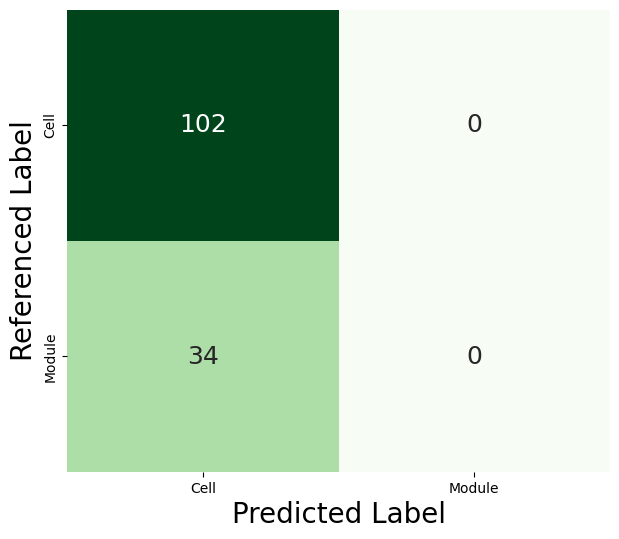

In [ ]:
labels = np.array([[c_label, f_m_label], [f_c_label,m_label]])

plt.figure(figsize=(7,6))
sns.heatmap(labels, cmap='Greens', annot=True, annot_kws={'size':18}, fmt='d', cbar=False, xticklabels=['Cell', 'Module'], yticklabels=['Cell', 'Module'])
sns.set(font_scale=2)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('Referenced Label', fontsize=20)